
# Multiple Linear Regression — (statsmodels)

This guided lab uses **statsmodels** to model `Stock_Index_Price` from macro features.
You'll practice both the **matrix API** and the **formula API**, run diagnostics,
and compute **confidence/prediction intervals** with theory.

**Dataset:** Monthly macro indicators (2016–2017).

> Version: **Activity (Student) — complete the TODOs**.


## Module 0 — Setup & Imports

In [1]:
import subprocess
import sys

packages = [
    'numpy',
    'pandas', 
    'statsmodels',
    'matplotlib',
    'seaborn',
    'scikit-learn',
    'ipython'
]

print("Starting package...")
subprocess.check_call([sys.executable, '-m', 'pip', 'install', '--upgrade'] + packages)
print("Successful package installed！")

Starting package...
Successful package installed！


In [2]:

# Core
import numpy as np
import pandas as pd
from IPython.display import display

# Modeling
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import jarque_bera

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Train/Test
from sklearn.model_selection import train_test_split

np.random.seed(42)

print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("statsmodels:", sm.__version__)


numpy: 2.3.3
pandas: 2.3.3
statsmodels: 0.14.5



## Module 1 — Load the Stock Market Dataset

Create DataFrame `stock_data` from the provided dictionary, then inspect structure.


In [3]:

Stock_Market = {'Year': [2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2016,2016,2016,2016,2016,2016,2016,2016,2016,2016,2016,2016],
                'Month': [12, 11,10,9,8,7,6,5,4,3,2,1,12,11,10,9,8,7,6,5,4,3,2,1],
                'Interest_Rate': [2.75,2.5,2.5,2.5,2.5,2.5,2.5,2.25,2.25,2.25,2,2,2,1.75,1.75,1.75,1.75,1.75,1.75,1.75,1.75,1.75,1.75,1.75],
                'Unemployment_Rate': [5.3,5.3,5.3,5.3,5.4,5.6,5.5,5.5,5.5,5.6,5.7,5.9,6,5.9,5.8,6.1,6.2,6.1,6.1,6.1,5.9,6.2,6.2,6.1],
                'Stock_Index_Price': [1464,1394,1357,1293,1256,1254,1234,1195,1159,1167,1130,1075,1047,965,943,958,971,949,884,866,876,822,704,719]}

stock_data = pd.DataFrame(Stock_Market, columns=['Year','Month','Interest_Rate','Unemployment_Rate','Stock_Index_Price'])

# Required exploration commands
print("Shape:", stock_data.shape)
print("\nInfo:")
stock_data.info()
print("\nDescribe:")
display(stock_data.describe(include='all'))


Shape: (24, 5)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Year               24 non-null     int64  
 1   Month              24 non-null     int64  
 2   Interest_Rate      24 non-null     float64
 3   Unemployment_Rate  24 non-null     float64
 4   Stock_Index_Price  24 non-null     int64  
dtypes: float64(2), int64(3)
memory usage: 1.1 KB

Describe:


,Year,Month,Interest_Rate,Unemployment_Rate,Stock_Index_Price
count,24.000000,24.000000,24.000000,24.00000,24.000000
mean,2016.500000,6.500000,2.072917,5.77500,1070.083333
std,0.510754,3.526299,0.349527,0.33002,210.735341
min,2016.000000,1.000000,1.750000,5.30000,704.000000
25%,2016.000000,3.750000,1.750000,5.50000,928.250000
50%,2016.500000,6.500000,2.000000,5.85000,1061.000000
75%,2017.000000,9.250000,2.500000,6.10000,1239.000000
max,2017.000000,12.000000,2.750000,6.20000,1464.000000



### Visualization — Pairplot & Heatmap

We visualize bivariate relationships and correlation structure.


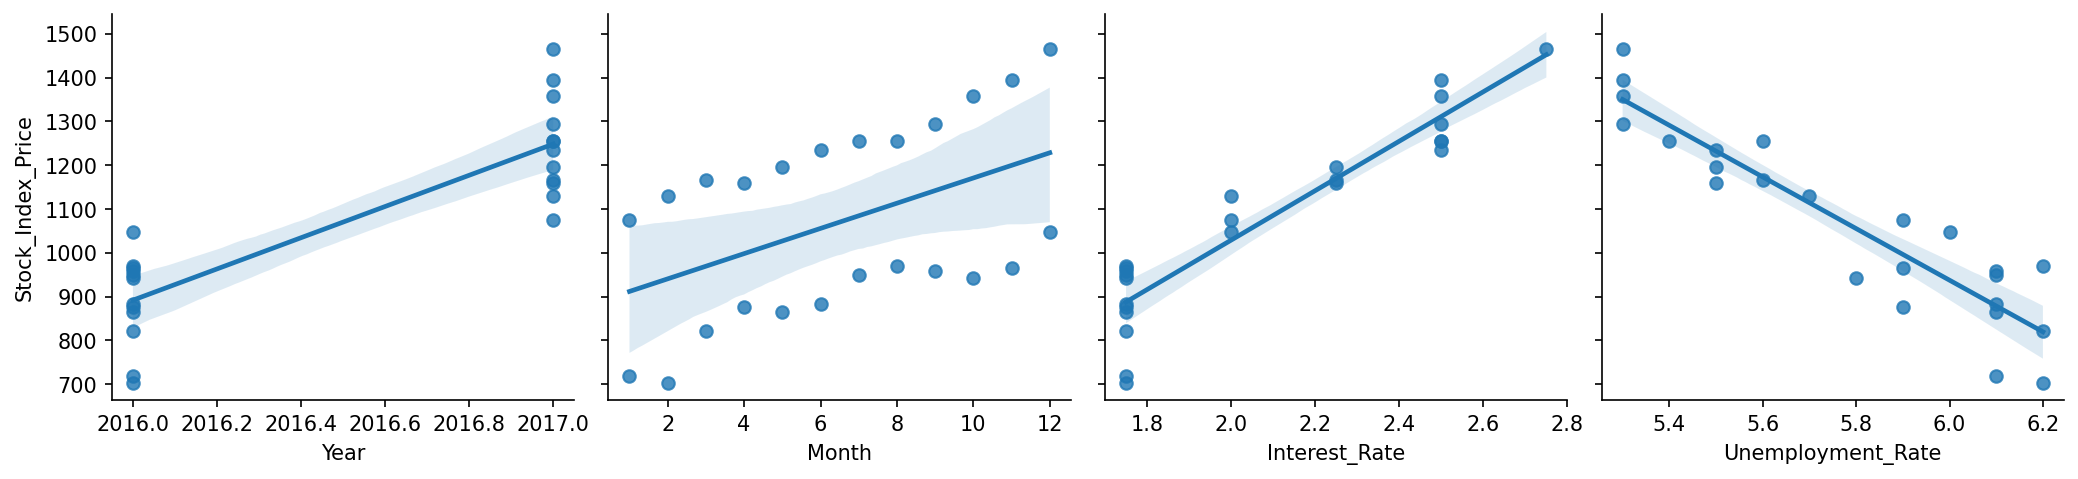

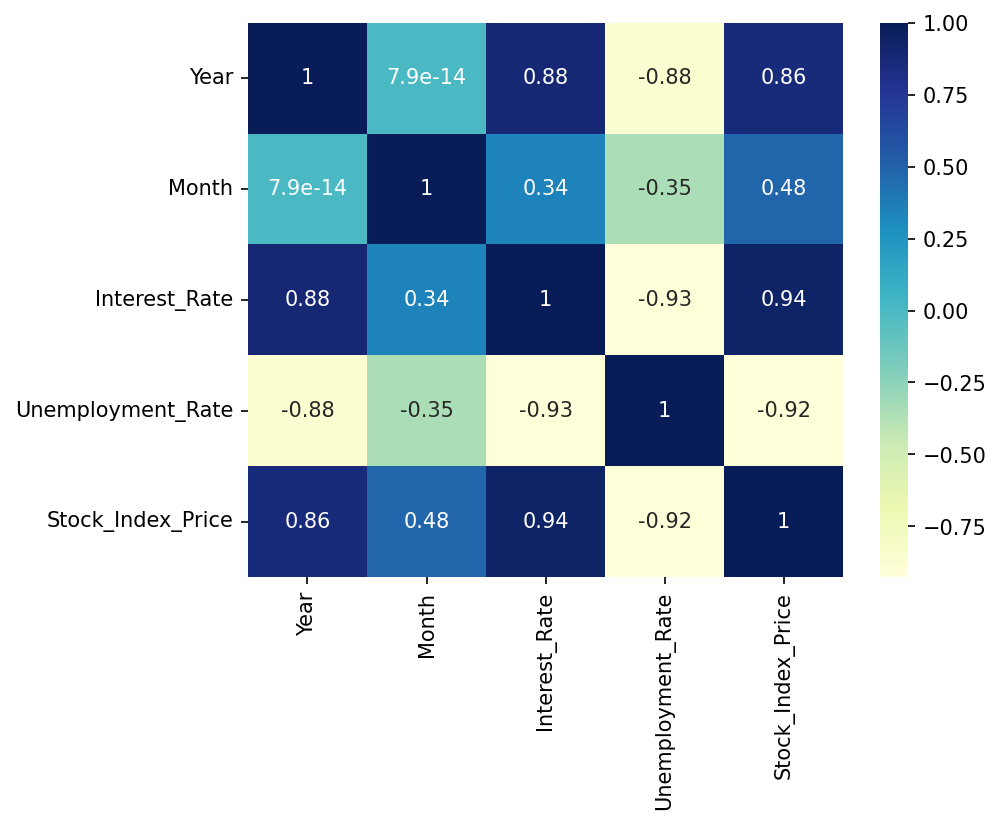

In [4]:

plt.rcParams['figure.dpi'] = 150

# Pairplot with regression lines
sns.pairplot(
    stock_data,
    x_vars=['Year','Month','Interest_Rate','Unemployment_Rate'],
    y_vars='Stock_Index_Price',
    height=3.2, aspect=1.1, kind='reg'
)
plt.show()

# Correlation heatmap
sns.heatmap(stock_data.corr(numeric_only=True), cmap="YlGnBu", annot=True)
plt.show()


## Module 2 — Theory Recap: OLS, Var$(\hat\beta)$, and Intervals

Consider the linear model $y = X\beta + \varepsilon$ with $\varepsilon \sim \mathcal{N}(0,\sigma^2 I_n)$.  
Here $X \in \mathbb{R}^{n\times p}$ includes a column of ones for the intercept.

---

### OLS estimator
$$
\hat{\beta} = \arg\min_b \|y - Xb\|_2^2 = (X^\top X)^{-1}X^\top y.
$$

**Sketch:** set the gradient  
$$
-2X^\top(y - Xb) = 0 \;\;\Rightarrow\;\; X^\top X b = X^\top y.
$$
If $X^\top X$ is invertible, solve for $b$.

---

### Sampling distribution and variance
$$
\hat{\beta} = \beta + (X^\top X)^{-1}X^\top\varepsilon,
\quad
\mathbb{E}[\hat{\beta}] = \beta,
\quad
\mathrm{Var}(\hat{\beta}) = \sigma^2 (X^\top X)^{-1}.
$$

An unbiased estimator for $\sigma^2$ is the residual variance:
$$
\hat{\sigma}^2 = \frac{1}{n-p}\,\|y - X\hat{\beta}\|_2^2.
$$

---

### Mean prediction at a new point
For $x_0 \in \mathbb{R}^p$, the fitted mean is
$$
\hat{y}_0 = x_0^\top \hat{\beta}, \quad
\mathrm{Var}(\hat{y}_0) = \hat{\sigma}^2\, x_0^\top (X^\top X)^{-1} x_0.
$$

---

**(1) Confidence interval for the mean** at $x_0$ (level $1-\alpha$):
$$
\hat{y}_0 \;\pm\; t_{\alpha/2,\,n-p}\,
\sqrt{\,\hat{\sigma}^2\, x_0^\top (X^\top X)^{-1} x_0\, }.
$$

**(2) Prediction interval for a new observation** at $x_0$:
$$
\hat{y}_0 \;\pm\; t_{\alpha/2,\,n-p}\,
\sqrt{\,\hat{\sigma}^2\,(1 + x_0^\top (X^\top X)^{-1} x_0)\, }.
$$


> We'll compute these from `statsmodels` and also manually using matrices.



## Module 3 — OLS with Matrix Inputs

We will fit `Stock_Index_Price ~ Year + Month + Interest_Rate + Unemployment_Rate` (you can remove `Year`).


In [6]:

# Select features
X_cols = ["Interest_Rate", "Unemployment_Rate"]  # TODO (activity): e.g., ["Interest_Rate", "Unemployment_Rate"]

X = sm.add_constant(stock_data[X_cols])
y = stock_data["Stock_Index_Price"]

model_basic = sm.OLS(y, X)
results_basic = model_basic.fit()
results_basic.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Stock_Index_Price   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     92.07
Date:                Fri, 03 Oct 2025   Prob (F-statistic):           4.04e-11
Time:                        19:25:22   Log-Likelihood:                -134.61
No. Observations:                  24   AIC:                             275.2
Df Residuals:                      21   BIC:                             278.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              1798.4040    899.248      2.000      0.059     -71.685    3668.493
Interest_Rate       345.5401    111.367      3.103      0.005     113.940     577.140
Unemployment_Rate  -250.1466    117.950     -2.121      0.046    -495.437      -4.856
==============================================================================
Omnibus:                        2.691   Durbin-Watson:                   0.530
Prob(Omnibus):                  0.260   Jarque-Bera (JB):                1.551
Skew:                          -0.612   Prob(JB):                        0.461
Kurtosis:                       3.226   Cond. No.                         394.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Manual computation of beta-hat and variance $\hat{\beta}$ and $\operatorname{Var}(\hat{\beta})$

Use matrix formulas and compare to `results_basic`.


In [7]:

XtX = X.T @ X
XtX_inv = np.linalg.inv(XtX)
Xty = X.T @ y.values
beta_hat_manual = XtX_inv @ Xty

residuals = y.values - (X.values @ beta_hat_manual)
n, p = X.shape
sigma2_hat = (residuals @ residuals) / (n - p)
var_beta_manual = sigma2_hat * XtX_inv

print("beta_hat (manual):\n", beta_hat_manual)
print("\nVar(beta) (manual):\n", var_beta_manual)
print("\nCompare to statsmodels params:\n", results_basic.params.values)


beta_hat (manual):
 [1798.40397763  345.54008701 -250.14657137]

Var(beta) (manual):
 [[ 808647.10038466  -95940.60446855 -105551.99388538]
 [ -95940.60446855   12402.59136595   12161.22356991]
 [-105551.99388538   12161.22356991   13912.17157753]]

Compare to statsmodels params:
 [1798.40397763  345.54008701 -250.14657137]


### Interpretation & 95% CI for a chosen coefficient

In [9]:

feature = "Interest_Rate"  # TODO: pick one string from X_cols
assert feature in X.columns, "Feature not in model design matrix."

coef = results_basic.params[feature]
ci_low, ci_high = results_basic.conf_int().loc[feature]
print(f"{feature} coef = {coef:.3f}")
print(f"95% CI: [{ci_low:.3f}, {ci_high:.3f}]")


Interest_Rate coef = 345.540
95% CI: [113.940, 577.140]


## Module 4 — OLS with Formula API (main effects & interaction)

When using the `statsmodels` **formula API**, it is important to understand the difference between **main effects** and **interaction effects**.

---

### 🔹 Main Effects
- Represent the **individual contribution** of each predictor to the response variable.  
- Each coefficient estimates the effect of a predictor **while holding other predictors constant**.  
- Example: including `x1 + x2` in a regression means that both predictors influence the outcome separately, without considering whether the effect of one depends on the other.  

📌 **Interpretation:**  
The coefficient of `x1` tells us how much the response is expected to change when `x1` increases by one unit, **assuming `x2` is fixed** (and vice versa).

---

### 🔹 Interaction Effects
- Represent the **combined influence** of predictors on the response.  
- They capture situations where the effect of one predictor **depends on the level of another predictor**.  
- In formulas, an interaction term (`x1:x2`) is automatically added when we specify `x1 * x2`.  
- This means the model includes:
  - The intercept  
  - The main effect of `x1`  
  - The main effect of `x2`  
  - The interaction term `x1 × x2`  

📌 **Interpretation:**  
If the interaction coefficient is significant, it implies that the relationship between `x1` and the response variable changes depending on the value of `x2`. In other words, the slope of `x1` is not constant — it varies with `x2`.  

---

### ✅ Key Takeaway
- **Main effects** show independent contributions of each predictor.  
- **Interaction effects** reveal whether predictors *modify each other’s influence* on the response.  
- Including interactions makes the model more flexible, but also more complex to interpret.  


In [10]:

# Main-effects formula
formula_main = "Stock_Index_Price ~ Interest_Rate + Unemployment_Rate"  # TODO (activity): include both macro predictors
fit_main = smf.ols(formula=formula_main, data=stock_data).fit()
fit_main.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Stock_Index_Price   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     92.07
Date:                Fri, 03 Oct 2025   Prob (F-statistic):           4.04e-11
Time:                        23:07:13   Log-Likelihood:                -134.61
No. Observations:                  24   AIC:                             275.2
Df Residuals:                      21   BIC:                             278.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          1798.4040    899.248      2.000      0.059     -71.685    3668.493
Interest_Rate       345.5401    111.367      3.103      0.005     113.940     577.140
Unemployment_Rate  -250.1466    117.950     -2.121      0.046    -495.437      -4.856
==============================================================================
Omnibus:                        2.691   Durbin-Watson:                   0.530
Prob(Omnibus):                  0.260   Jarque-Bera (JB):                1.551
Skew:                          -0.612   Prob(JB):                        0.461
Kurtosis:                       3.226   Cond. No.                         394.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:

# Interaction formula
formula_inter = "Stock_Index_Price ~ Interest_Rate * Unemployment_Rate"  # TODO (activity): add at least one interaction
fit_inter = smf.ols(formula=formula_inter, data=stock_data).fit()
fit_inter.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Stock_Index_Price   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     58.74
Date:                Fri, 03 Oct 2025   Prob (F-statistic):           4.27e-10
Time:                        23:07:17   Log-Likelihood:                -134.56
No. Observations:                  24   AIC:                             277.1
Df Residuals:                      20   BIC:                             281.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                        2522.8485   2634.045      0.958      0.350   -2971.673    8017.370
Interest_Rate                     -32.4913   1293.064     -0.025      0.980   -2729.776    2664.794
Unemployment_Rate                -380.7610    461.086     -0.826      0.419   -1342.569     581.047
Interest_Rate:Unemployment_Rate    68.5397    233.531      0.293      0.772    -418.597     555.676
==============================================================================
Omnibus:                        2.146   Durbin-Watson:                   0.531
Prob(Omnibus):                  0.342   Jarque-Bera (JB):                1.205
Skew:                          -0.544   Prob(JB):                        0.547
Kurtosis:                       3.142   Cond. No.                     2.70e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.7e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""


## Module 5 — Predictions with Confidence & Prediction Intervals

Use the **main effects model** to predict for new macro scenarios.
Make sure `new_df` has all predictors in your formula.


In [12]:

new_df = pd.DataFrame({
    "Interest_Rate": [2.0, 2.5, 3.0],        # TODO: list of floats
    "Unemployment_Rate": [5.5, 6.0, 6.5],    # TODO: list of floats
})

pred = fit_main.get_prediction(new_df).summary_frame(alpha=0.05)
# mean_ci_lower/upper = CI for the mean; obs_ci_lower/upper = Prediction Interval
pd.concat([new_df, pred], axis=1)


,Interest_Rate,Unemployment_Rate,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,2.0,5.5,1113.678009,42.581968,1025.123959,1202.232059,942.286935,1285.069084
1,2.5,6.0,1161.374767,74.237668,1006.989085,1315.760449,948.377069,1374.372465
2,3.0,6.5,1209.071525,185.816694,822.644556,1595.498494,795.720726,1622.422324


## Module 6 — Train/Test Split (70/30)

In [15]:

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=1)
print("Train shapes:", X_train.shape, y_train.shape)
print("Test shapes:", X_test.shape, y_test.shape)

# TODO: Fit on X_train/y_train and compute Train adjusted R^2
# model_train = sm.OLS( ... ).fit()
# print("Train R^2 adj:", ...)

# TODO: Predict on X_test, compute Test R^2 manually
# y_pred_test = model_train.predict( ... )
# SS_res = ((y_test - y_pred_test)**2).sum()
# SS_tot = ((y_test - y_test.mean())**2).sum()
# R2_test = 1 - SS_res/SS_tot
# print("Test R^2:", R2_test)

# Fit on training data
model_train = sm.OLS(y_train, X_train).fit()
print("Train R^2 adj:", model_train.rsquared_adj)

# Predict on test set
y_pred_test = model_train.predict(X_test)

# Compute Test R^2 manually
SS_res = ((y_test - y_pred_test) ** 2).sum()
SS_tot = ((y_test - y_test.mean()) ** 2).sum()
R2_test = 1 - SS_res / SS_tot
print("Test R^2:", R2_test)

Train shapes: (16, 3) (16,)
Test shapes: (8, 3) (8,)
Train R^2 adj: 0.8819443046778639
Test R^2: 0.8669144981016874



## Module 7 — Regression Diagnostics: Checking OLS Assumptions

After fitting a regression model, we need to check the assumptions of **Ordinary Least Squares (OLS)**:

1. **Linearity** – the relationship between predictors and response is linear.  
2. **Normality** – residuals are normally distributed.  
3. **Homoscedasticity** – residuals have constant variance.  
4. **Independence** – residuals are uncorrelated.  
5. **No high influence points** – no single point dominates the fit.

---

## Residual Diagnostics: QQ-Plot and Residuals Analysis

After fitting a regression model, it’s important to check whether the assumptions of **Ordinary Least Squares (OLS)** are approximately satisfied.  
We use residual plots to assess **normality, homoscedasticity, linearity, and influence**.

---

### 1. QQ-Plot of Residuals
- Compares the quantiles of the residuals with the quantiles of a standard normal distribution.  
- If residuals are normally distributed, the points should lie close to the 45° line.  
- Strong deviations (curved patterns, heavy tails) indicate **non-normality**.

---

### 2. Residuals vs. Fitted Values
- Scatter plot of residuals against the predicted (fitted) values.  
- The residuals should look like random noise, centered around 0.  
- **Patterns** (e.g., funnel shape, curvature) suggest **heteroscedasticity** (non-constant variance) or **model misspecification**.

---

### 3. Histogram of Residuals
- Shows the overall distribution of residuals.  
- Helps confirm if residuals are approximately **bell-shaped (normal)** and centered around 0.  
- Skewness or heavy tails indicate violations of normality.

---

### 4. Residuals vs. Observed Response ($y$)
- Plots residuals against the actual observed $y$ values.  
- Should show no visible trend.  
- Curvature or systematic deviations suggest **nonlinearity** or missing variables.  
- Large residuals highlight possible **outliers**.

---

### 5. Residuals vs. Predictors ($x_j$)
- Plots residuals against each predictor variable.  
- Checks whether the assumed linear relationship is adequate.  
- Random scatter is desired.  
- **Patterns** (curves, increasing spread) indicate a need for transformations or additional terms.

---

### 6. Influence Diagnostics (Cook’s Distance, Leverage)
  Identifies outliers and influential points. Large Cook’s distance or high leverage means the point strongly affects model fit.  

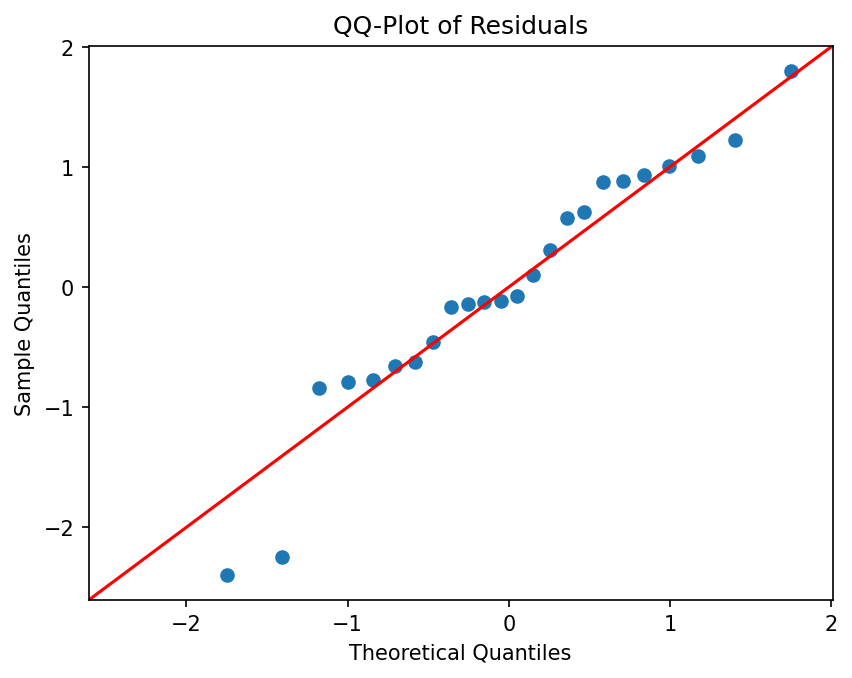

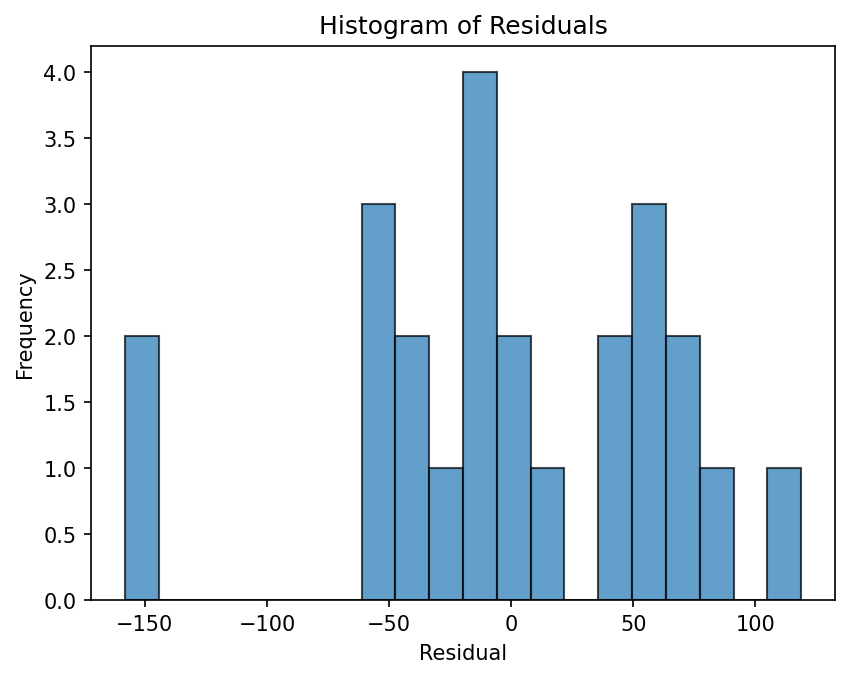

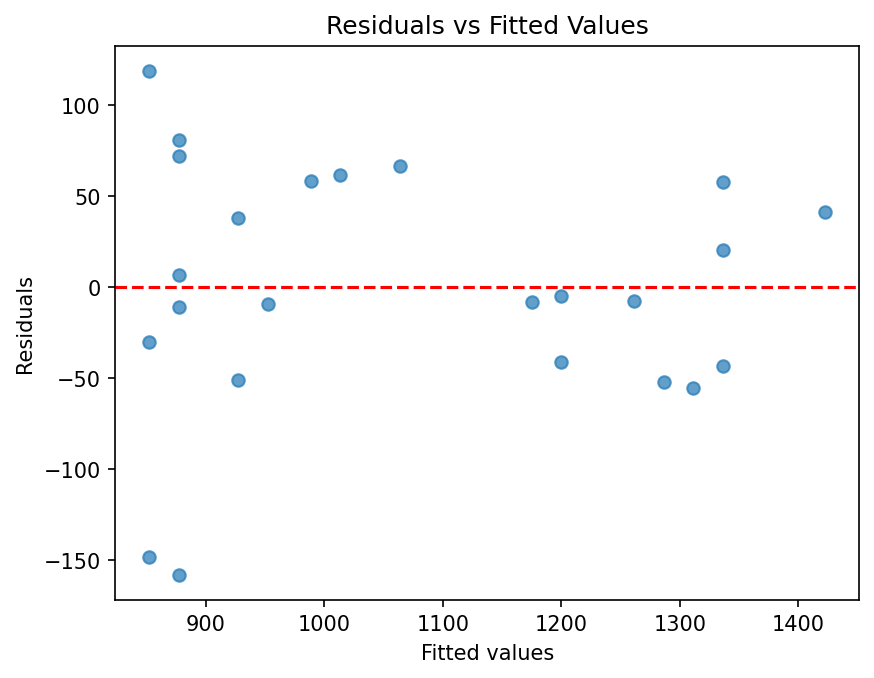

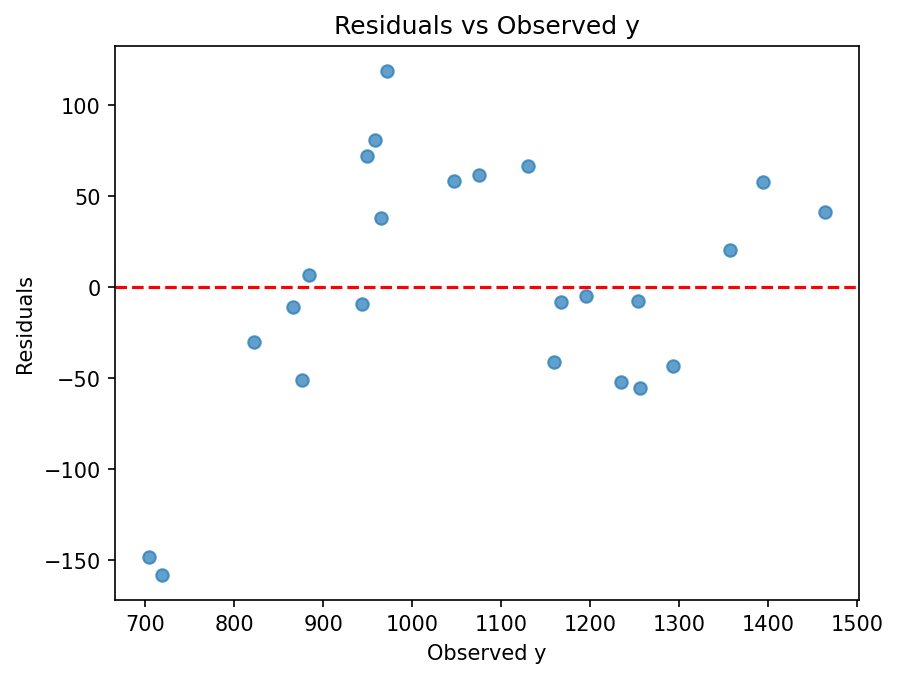

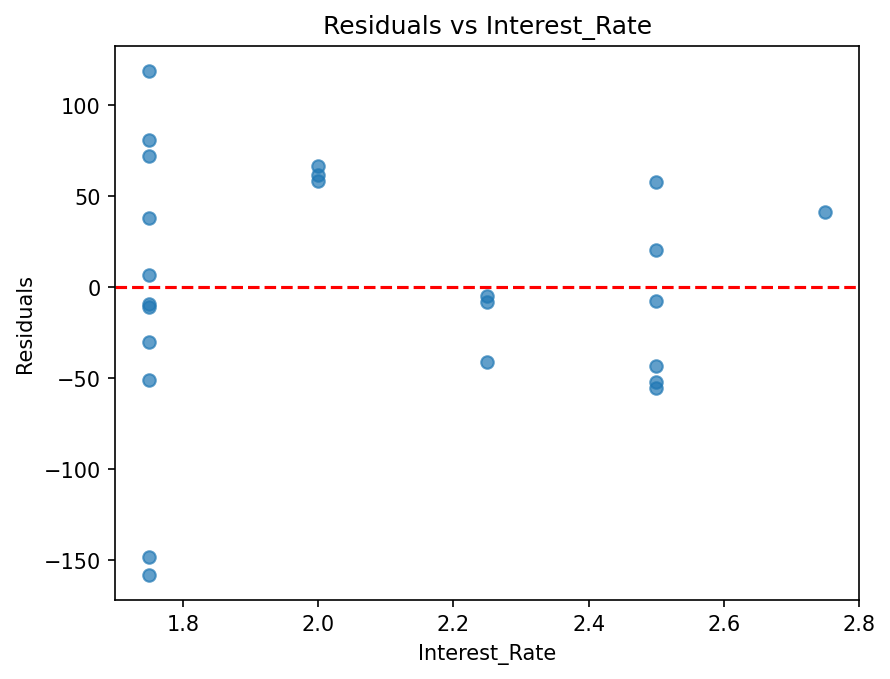

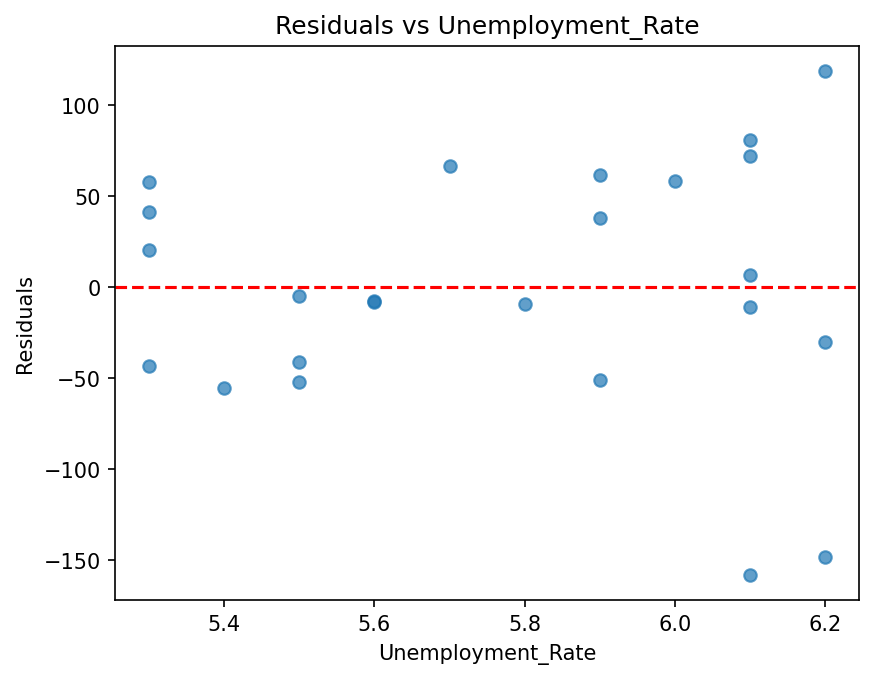

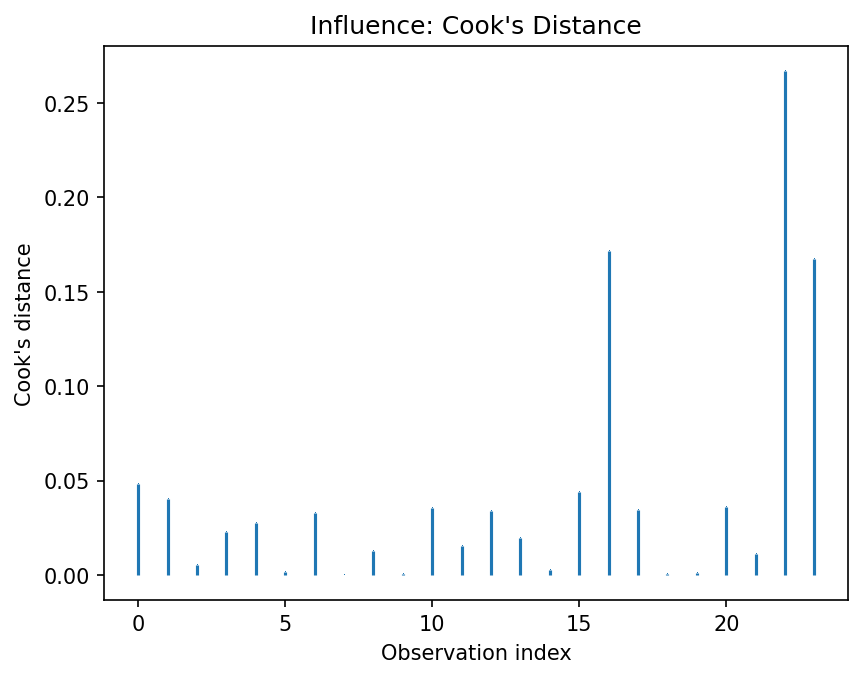

In [18]:
# TODO: extract residuals from the model of interest
# TODO:
res = fit_main       # my fitted model
resid = res.resid    # residuals

# --- 1. QQ-plot ---
sm.qqplot(resid, line="45", fit=True)
plt.title("QQ-Plot of Residuals")
plt.show()

# --- 2. Histogram of residuals ---
plt.hist(resid, bins=20, edgecolor="k", alpha=0.7)
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.show()

# --- 3. Residuals vs. fitted values ---
plt.scatter(res.fittedvalues, resid, alpha=0.7)
plt.axhline(y=0, color="red", linestyle="--")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values")
plt.show()

# --- 4. Residuals vs observed y ---
plt.scatter(res.model.endog, resid, alpha=0.7)
plt.axhline(y=0, color="red", linestyle="--")
plt.xlabel("Observed y")
plt.ylabel("Residuals")
plt.title("Residuals vs Observed y")
plt.show()

# --- 5. Residuals vs each predictor ---
for col in X_for_vif.columns:
    if col.lower().startswith("const"):
        continue
    plt.scatter(X_for_vif[col], resid, alpha=0.7)
    plt.axhline(y=0, color="red", linestyle="--")
    plt.xlabel(col)
    plt.ylabel("Residuals")
    plt.title(f"Residuals vs {col}")
    plt.show()

# --- 6. Influence diagnostics (Cook's distance) ---
influence = res.get_influence()
(c, p) = influence.cooks_distance
plt.stem(np.arange(len(c)), c, markerfmt=",", basefmt=" ")
plt.xlabel("Observation index")
plt.ylabel("Cook's distance")
plt.title("Influence: Cook's Distance")
plt.show()



## Module 8 — Prediction and confidence intervals

For a new point \(x_0\), you need to write a function that returns:
- `mean_ci_lower/upper` → **Confidence interval** for the mean prediction \( \hat{y}_0 \)
- `obs_pi_lower/upper`  → **Prediction interval** for a new observation at \(x_0\)

### TODO: Write your own function to extract the prediction and confidence intervals.

In [ ]:

def get_prediction(model,alpha=0.05):
    
    ## TODO
    
    return mean_ci_lower, mean_ci_upper, obs_pi_lower, obs_pi_upper

# Display your output for the main effects model with no interactions in a pandas dataframe

# TODO:  
df_train = pd.DataFrame(columns=['y_true','y_pred','Lower 95% PI', 'Upper 95% PI','Lower 95% CI', 'Upper 95% CI'])
display(df_train)

df_test = pd.DataFrame(columns=['y_true','y_pred','Lower 95% PI', 'Upper 95% PI','Lower 95% CI', 'Upper 95% CI'])

display(df_test)

,y_true,y_pred,Lower 95% PI,Upper 95% PI,Lower 95% CI,Upper 95% CI
0,1357,1345.740741,1154.693099,1536.788382,1264.743112,1426.738370
1,866,861.703704,676.550988,1046.856420,795.802695,927.604712
2,1234,1300.148148,1112.024878,1488.271418,1226.311982,1373.984314
3,1195,1199.592593,1008.544951,1390.640234,1118.594963,1280.590222
4,822,838.907407,652.263504,1025.551310,768.926259,908.888556
5,1394,1345.740741,1154.693099,1536.788382,1264.743112,1426.738370
6,971,838.907407,652.263504,1025.551310,768.926259,908.888556
7,1464,1446.296296,1243.973418,1648.619175,1341.434664,1551.157929
8,958,861.703704,676.550988,1046.856420,795.802695,927.604712
9,719,861.703704,676.550988,1046.856420,795.802695,927.604712


,y_true,y_pred,Lower 95% PI,Upper 95% PI,Lower 95% CI,Upper 95% CI
0,965,907.296296,696.913177,1117.679415,787.619768,1026.972824
1,884,861.703704,676.550988,1046.856420,795.802695,927.604712
2,1293,1345.740741,1154.693099,1536.788382,1264.743112,1426.738370
3,943,930.092593,696.009267,1164.175919,772.433409,1087.751776
4,876,907.296296,696.913177,1117.679415,787.619768,1026.972824
5,949,861.703704,676.550988,1046.856420,795.802695,927.604712
6,1130,1053.444444,855.741419,1251.147470,957.799784,1149.089105
7,1256,1322.944444,1138.291467,1507.597422,1258.460827,1387.428061


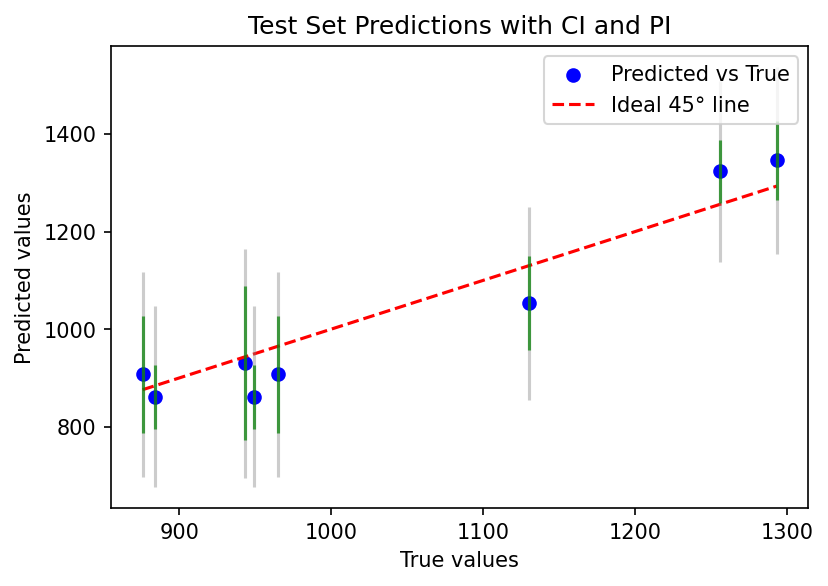

In [22]:
# Module 8 — Prediction and Confidence Intervals

def get_prediction(model, X_new, alpha=0.05):
    pred = model.get_prediction(X_new).summary_frame(alpha=alpha)
    mean_ci_lower = pred["mean_ci_lower"].values
    mean_ci_upper = pred["mean_ci_upper"].values
    obs_pi_lower  = pred["obs_ci_lower"].values
    obs_pi_upper  = pred["obs_ci_upper"].values
    return mean_ci_lower, mean_ci_upper, obs_pi_lower, obs_pi_upper


# ---- Train set predictions ----
y_pred_train = model_train.predict(X_train)
mean_ci_lower, mean_ci_upper, obs_pi_lower, obs_pi_upper = get_prediction(model_train, X_train)

df_train = pd.DataFrame({
    "y_true": y_train.values,
    "y_pred": y_pred_train.values,
    "Lower 95% PI": obs_pi_lower,
    "Upper 95% PI": obs_pi_upper,
    "Lower 95% CI": mean_ci_lower,
    "Upper 95% CI": mean_ci_upper
})
display(df_train)


# ---- Test set predictions ----
y_pred_test = model_train.predict(X_test)
mean_ci_lower, mean_ci_upper, obs_pi_lower, obs_pi_upper = get_prediction(model_train, X_test)

df_test = pd.DataFrame({
    "y_true": y_test.values,
    "y_pred": y_pred_test.values,
    "Lower 95% PI": obs_pi_lower,
    "Upper 95% PI": obs_pi_upper,
    "Lower 95% CI": mean_ci_lower,
    "Upper 95% CI": mean_ci_upper
})
display(df_test)


# Visualization helper: CI and PI bands
def plot_predictions_with_intervals(y_true, y_pred, ci_lower, ci_upper, pi_lower, pi_upper, title="Prediction Intervals"):
    plt.figure(figsize=(6,4))
    plt.scatter(y_true, y_pred, label="Predicted vs True", color="blue")
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], "r--", label="Ideal 45° line")

    # Plot intervals as vertical error bars
    for i in range(len(y_true)):
        plt.vlines(y_true.iloc[i], pi_lower[i], pi_upper[i], color="gray", alpha=0.4)   # Prediction interval
        plt.vlines(y_true.iloc[i], ci_lower[i], ci_upper[i], color="green", alpha=0.7)  # Confidence interval

    plt.xlabel("True values")
    plt.ylabel("Predicted values")
    plt.title(title)
    plt.legend()
    plt.show()


# Example usage: visualize test set predictions
plot_predictions_with_intervals(
    y_true=y_test,
    y_pred=y_pred_test,
    ci_lower=df_test["Lower 95% CI"],
    ci_upper=df_test["Upper 95% CI"],
    pi_lower=df_test["Lower 95% PI"],
    pi_upper=df_test["Upper 95% PI"],
    title="Test Set Predictions with CI and PI"
)


,y_true,y_pred,Lower 95% PI,Upper 95% PI,Lower 95% CI,Upper 95% CI
0,1357,1345.740741,1154.693099,1536.788382,1264.743112,1426.738370
1,866,861.703704,676.550988,1046.856420,795.802695,927.604712
2,1234,1300.148148,1112.024878,1488.271418,1226.311982,1373.984314
3,1195,1199.592593,1008.544951,1390.640234,1118.594963,1280.590222
4,822,838.907407,652.263504,1025.551310,768.926259,908.888556
5,1394,1345.740741,1154.693099,1536.788382,1264.743112,1426.738370
6,971,838.907407,652.263504,1025.551310,768.926259,908.888556
7,1464,1446.296296,1243.973418,1648.619175,1341.434664,1551.157929
8,958,861.703704,676.550988,1046.856420,795.802695,927.604712
9,719,861.703704,676.550988,1046.856420,795.802695,927.604712


,y_true,y_pred,Lower 95% PI,Upper 95% PI,Lower 95% CI,Upper 95% CI
0,965,907.296296,696.913177,1117.679415,787.619768,1026.972824
1,884,861.703704,676.550988,1046.856420,795.802695,927.604712
2,1293,1345.740741,1154.693099,1536.788382,1264.743112,1426.738370
3,943,930.092593,696.009267,1164.175919,772.433409,1087.751776
4,876,907.296296,696.913177,1117.679415,787.619768,1026.972824
5,949,861.703704,676.550988,1046.856420,795.802695,927.604712
6,1130,1053.444444,855.741419,1251.147470,957.799784,1149.089105
7,1256,1322.944444,1138.291467,1507.597422,1258.460827,1387.428061


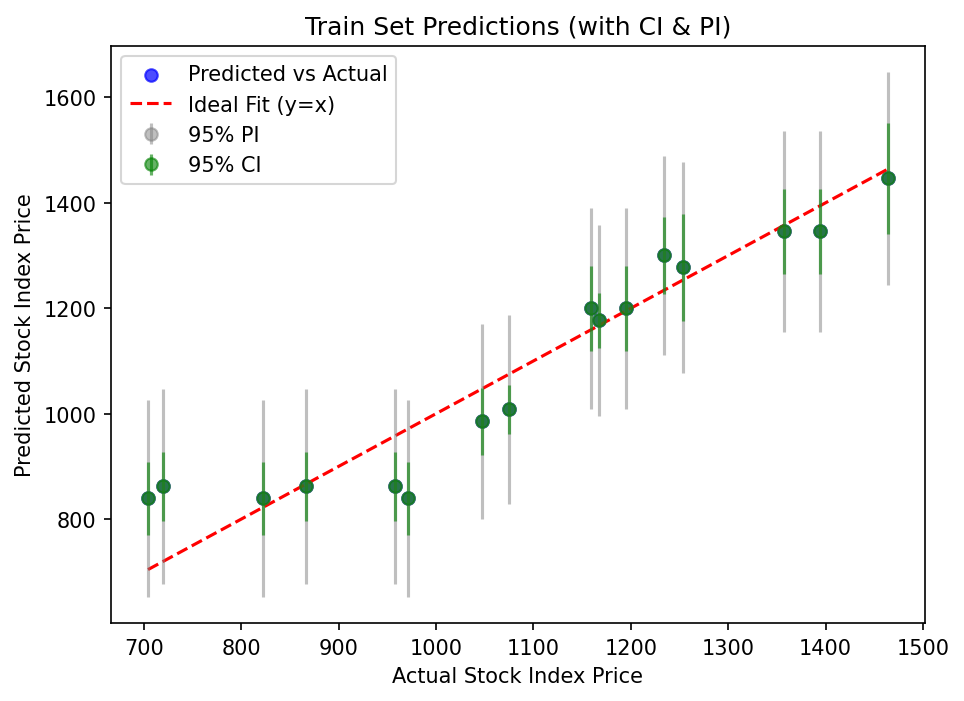

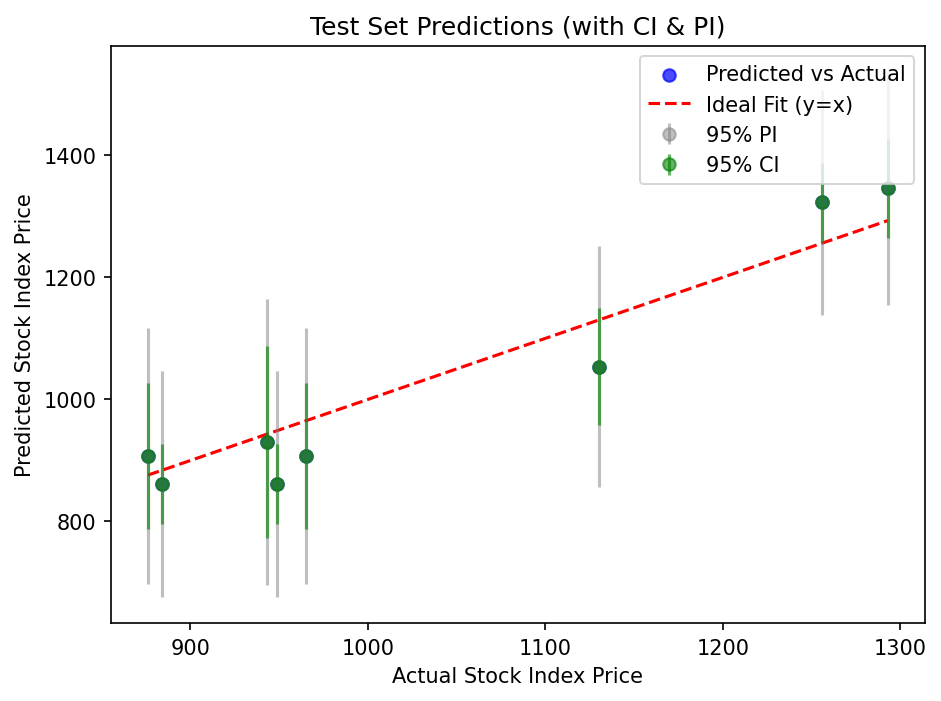

In [23]:
# Module 8 — Prediction and confidence intervals


def get_prediction(model, X_new, alpha=0.05):
    """
    Compute mean CI and prediction interval for new points.
    model: fitted statsmodels OLS
    X_new: design matrix (with const column!)
    alpha: significance level
    """
    # Get prediction summary frame
    pred = model.get_prediction(X_new).summary_frame(alpha=alpha)
    
    # Extract intervals
    mean_ci_lower = pred["mean_ci_lower"].values
    mean_ci_upper = pred["mean_ci_upper"].values
    obs_pi_lower  = pred["obs_ci_lower"].values
    obs_pi_upper  = pred["obs_ci_upper"].values
    
    return mean_ci_lower, mean_ci_upper, obs_pi_lower, obs_pi_upper


# ---- Train set ----
y_pred_train = model_train.predict(X_train)

mean_ci_lower, mean_ci_upper, obs_pi_lower, obs_pi_upper = get_prediction(model_train, X_train)

df_train = pd.DataFrame({
    "y_true": y_train.values,
    "y_pred": y_pred_train.values,
    "Lower 95% PI": obs_pi_lower,
    "Upper 95% PI": obs_pi_upper,
    "Lower 95% CI": mean_ci_lower,
    "Upper 95% CI": mean_ci_upper
})

display(df_train)


# ---- Test set ----
y_pred_test = model_train.predict(X_test)

mean_ci_lower, mean_ci_upper, obs_pi_lower, obs_pi_upper = get_prediction(model_train, X_test)

df_test = pd.DataFrame({
    "y_true": y_test.values,
    "y_pred": y_pred_test.values,
    "Lower 95% PI": obs_pi_lower,
    "Upper 95% PI": obs_pi_upper,
    "Lower 95% CI": mean_ci_lower,
    "Upper 95% CI": mean_ci_upper
})

display(df_test)


# Data Visualization-------------------------
def plot_predictions(df, title="Predictions with CI and PI"):
    plt.figure(figsize=(7,5))
    plt.scatter(df["y_true"], df["y_pred"], color="blue", alpha=0.7, label="Predicted vs Actual")
    plt.plot([df["y_true"].min(), df["y_true"].max()],
             [df["y_true"].min(), df["y_true"].max()],
             "r--", label="Ideal Fit (y=x)")

    # Plot (PI)
    plt.errorbar(df["y_true"], df["y_pred"],
                 yerr=[df["y_pred"] - df["Lower 95% PI"], 
                       df["Upper 95% PI"] - df["y_pred"]],
                 fmt="o", color="gray", alpha=0.5, label="95% PI")

    # Plot (CI)
    plt.errorbar(df["y_true"], df["y_pred"],
                 yerr=[df["y_pred"] - df["Lower 95% CI"], 
                       df["Upper 95% CI"] - df["y_pred"]],
                 fmt="o", color="green", alpha=0.6, label="95% CI")

    plt.xlabel("Actual Stock Index Price")
    plt.ylabel("Predicted Stock Index Price")
    plt.title(title)
    plt.legend()
    plt.show()

plot_predictions(df_train, title="Train Set Predictions (with CI & PI)")
plot_predictions(df_test, title="Test Set Predictions (with CI & PI)")
